# Decision Trees and PCA

Author: Ridha Fathima Mohideen Malik

The goal of this notebook is to understand decision trees and principal component analysis (PCA) in the context of imbalanced datasets. We look at possibilities to improve the model without oversampling and/or undersampling.

In [ ]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import Image  
import pydotplus

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore', message='FutureWarning')

## Pre-processing data with PCA

In [57]:
# importing data

lc = pd.read_csv('D:/comp-astro/comp-astro/exoplanet-data/star_exo_lc.csv', sep=',')
lc['LABEL_BIN'] = np.where(lc['LABEL']==2, 1, 0) ## replacing labels for binary value: 1 - has exoplanet, 0 - no exoplanet

targets = lc['LABEL_BIN']
lc_ft = lc.drop(labels=['LABEL', 'LABEL_BIN'], axis=1)
targets.value_counts()

0    5615
1      42
Name: LABEL_BIN, dtype: int64

Our dataset is high-dimensional and imbalanced. We will use PCA to reduce dimensionality and use k-fold cross validation for train and test.

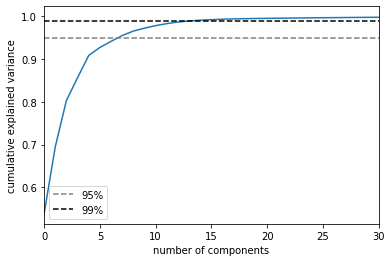

In [43]:
# estimating number of components for pca

pca = PCA().fit(lc_ft)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.95, linestyle='--', c='gray', label='95%')
plt.axhline(0.99, linestyle='--', c='black', label='99%')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim(0, 30)
plt.legend()

In [59]:
# pca fit

pca = PCA(n_components=15)
lc_pca = pca.fit_transform(lc_ft)
lc_pca = pd.DataFrame(lc_pca)
lc_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-15412.350021,-8136.681773,-7327.012135,-4042.440735,-24.074548,-3296.031948,-129.704122,-1683.585770,-1218.771491,-2030.280737,-831.415341,-1499.130433,1.600386,-684.885283,-390.635878
1,-15614.782248,-9065.203594,-6651.244220,-4843.218092,-665.409731,-2165.117282,264.183201,-2406.772523,-514.227268,-2048.222314,-611.458041,-1714.619249,-934.601989,-786.693234,-701.907411
2,-16996.524716,-7106.999171,-9776.374390,-9627.663293,441.147700,-1619.001047,1084.653372,-3242.211827,1888.100635,-974.530003,-459.673070,-3450.296006,23.262996,-991.475058,-56.027111
3,-15312.746481,-8588.413130,-6924.347241,-5607.463212,70.336796,-2559.600720,87.667155,-1550.843291,-615.749674,-2178.651099,-712.689914,-1240.812467,-1164.214538,-817.821862,-328.447703
4,-13663.548164,-14517.776455,-10470.761769,4100.875040,-5323.617314,-5082.844186,798.620643,-2864.567124,624.378786,-573.304102,123.929984,-7185.210279,565.654313,-1017.515725,19.890413


<AxesSubplot:>

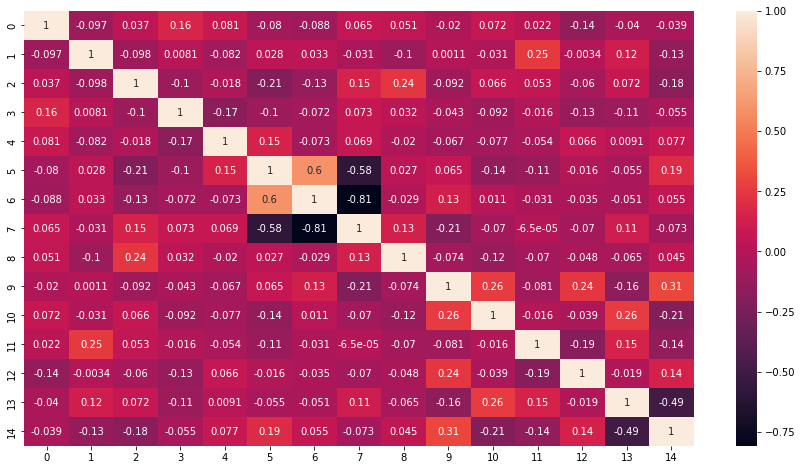

In [109]:
# check correlation

plt.figure(figsize=(15,8))
sns.heatmap(lc_pca.corr(method='spearman'), annot=True)

## Simple decision tree

In [61]:
model = DecisionTreeClassifier(random_state=42)

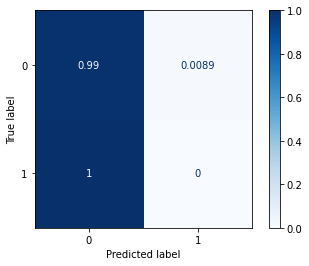

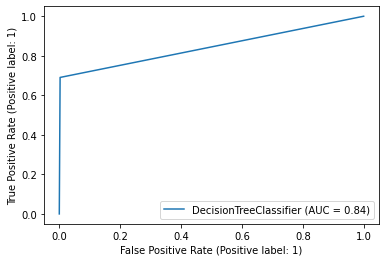

In [65]:
X_train, X_test, y_train, y_test = train_test_split(lc_pca, targets, test_size=0.30, random_state=42)

model.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=[0,1],
    cmap=plt.cm.Blues,
    normalize='true',
)

RocCurveDisplay.from_estimator(model, lc_pca, targets)

The model completely fails to classify our object of interest - exoplanets.

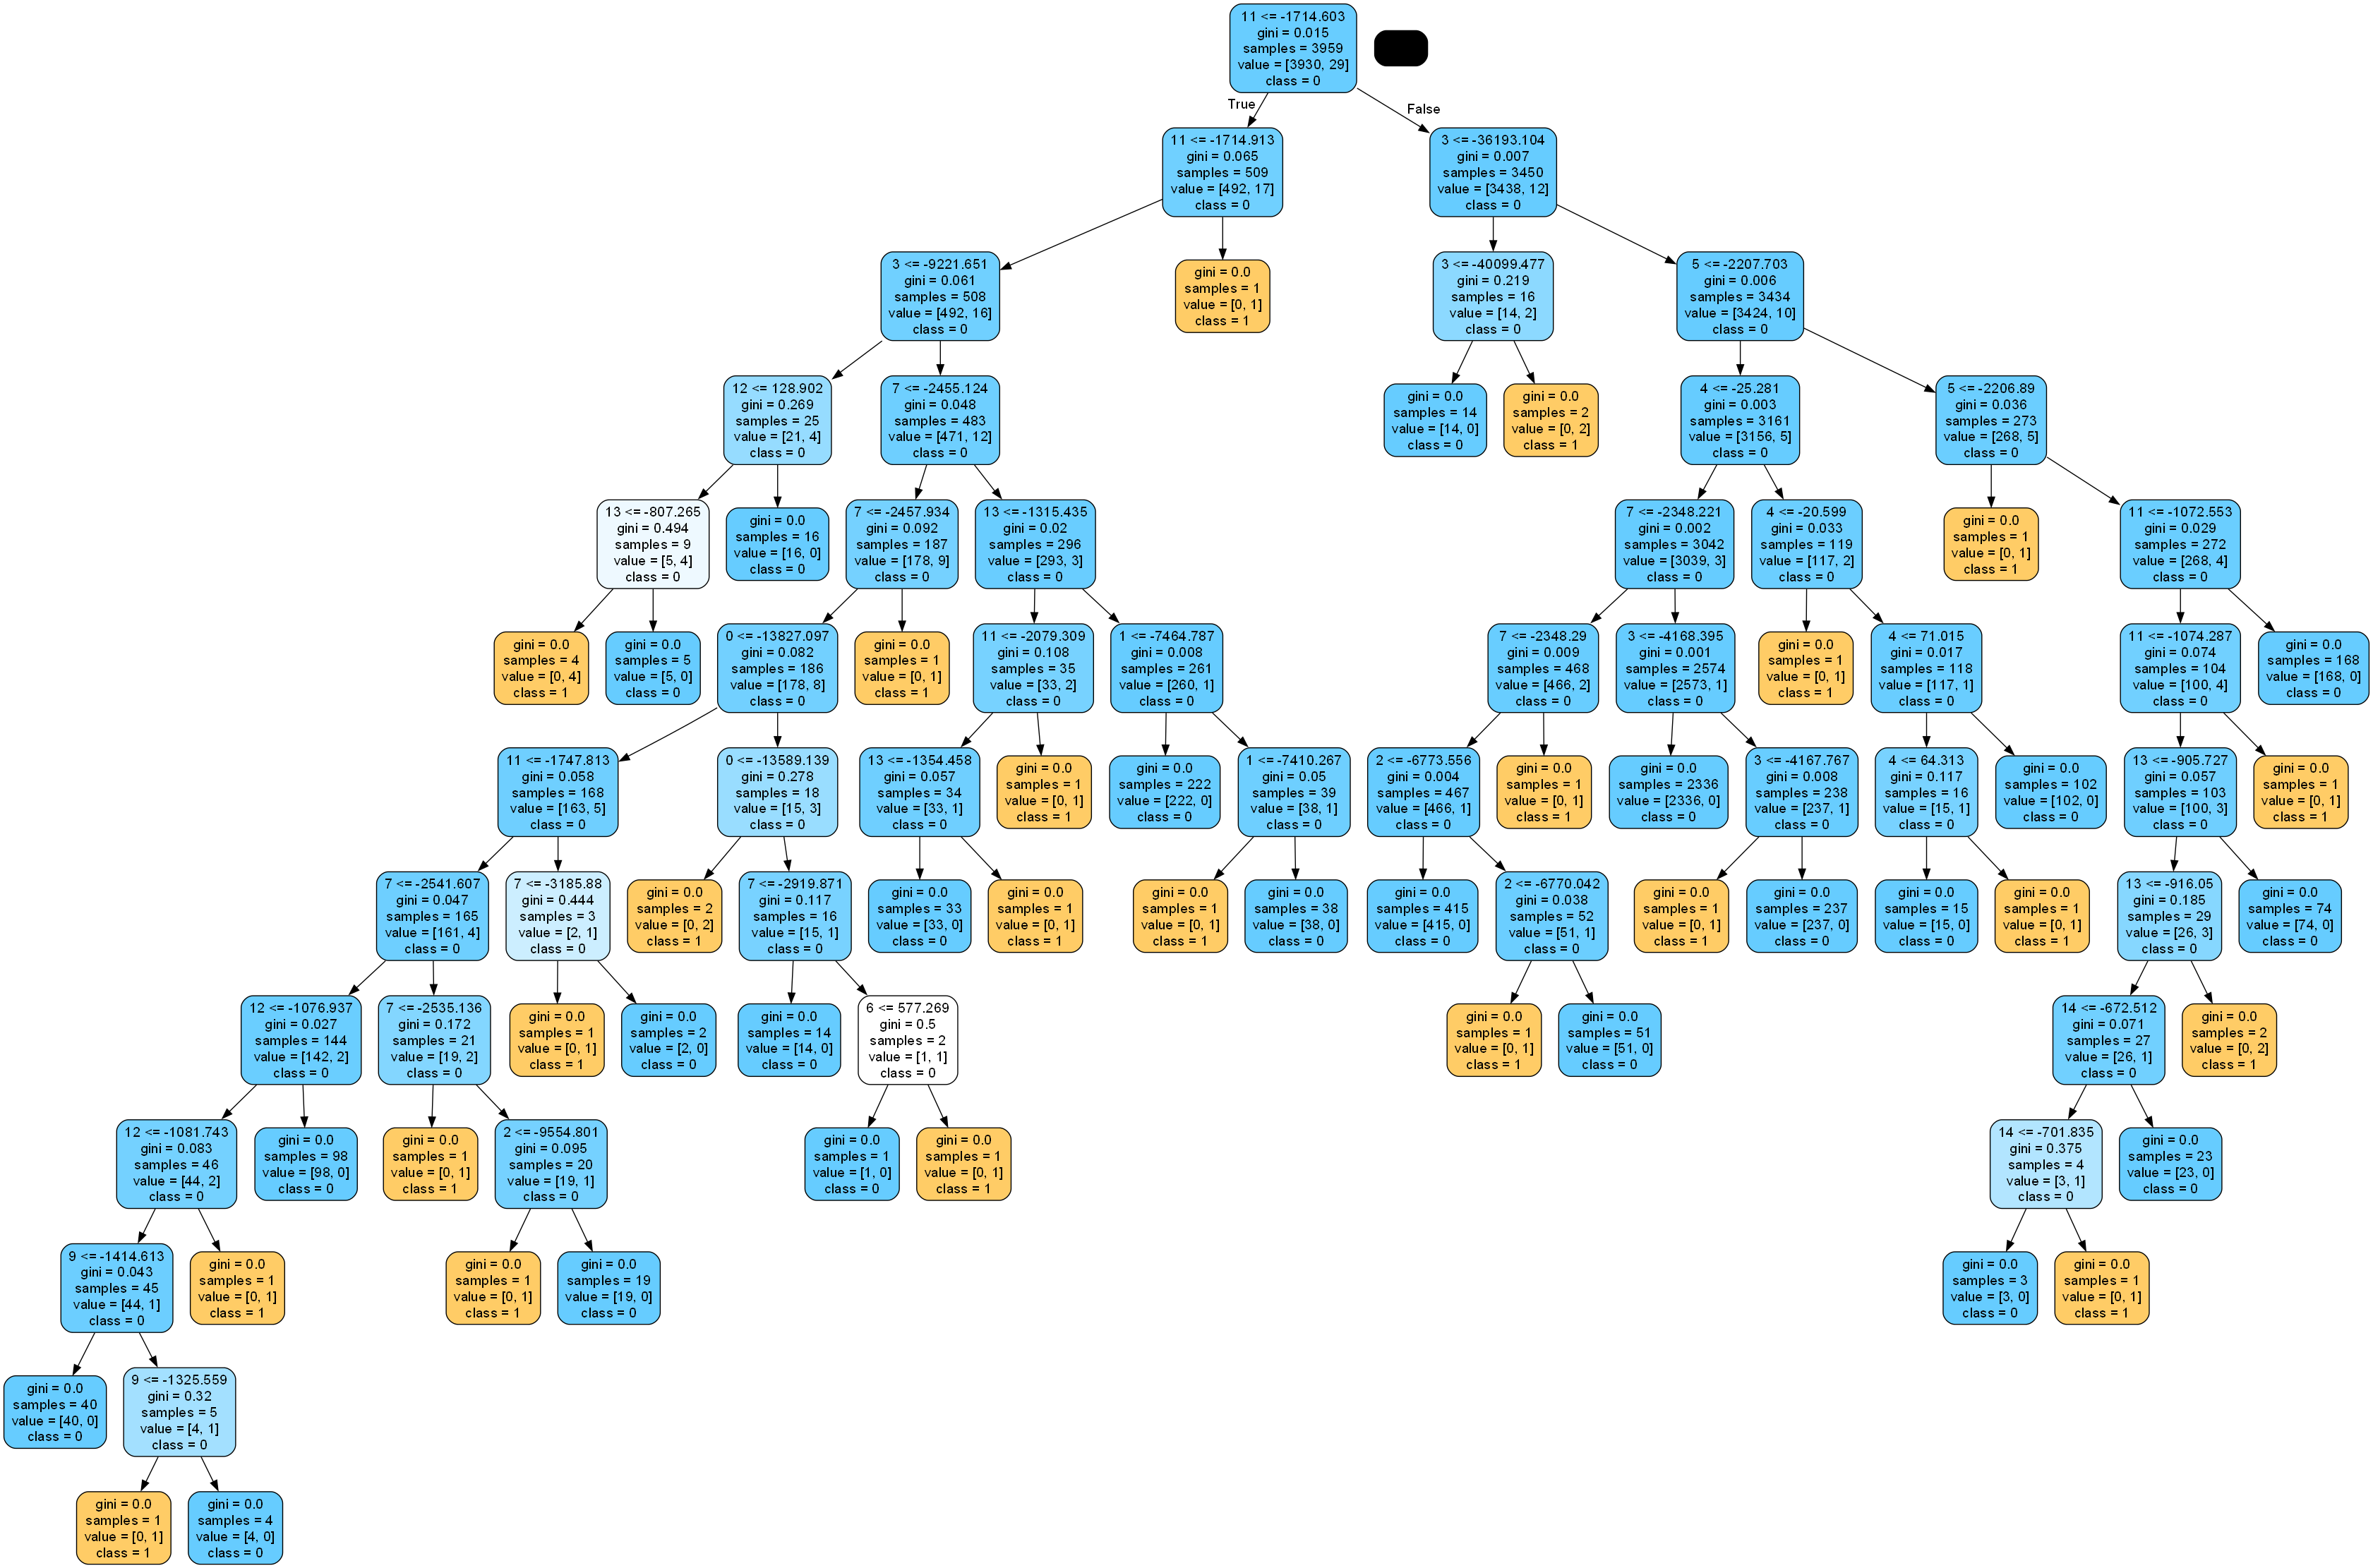

In [70]:
# visualising the tre
# taken from Viviana Acquaviva's lectures at CCA Flatiron

dot_data = StringIO()
export_graphviz(
            model,
            out_file =  dot_data,
            feature_names = lc_pca.columns,
            class_names = ['0','1'],
            filled = True,
            rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
nodes = graph.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
        values = [255 * v / sum(values) for v in values]
        
        values = [int(255 * v / sum(values)) for v in values]
            
        if values[0] > values[1]:
            alpha = int(values[0] - values[1])
            alpha = '{:02x}'.format(alpha) #turn into hexadecimal
            color = '#66ccff'+str(alpha)
        else:
            alpha = int(values[1] - values[0])
            alpha = '{:02x}'.format(alpha)
            color = '#ffcc66'+str(alpha)
        node.set_fillcolor(color)

graph.set_dpi('100')

Image(graph.create_png())
#Image(graph.write_png())

There is an overfitting of the DT. 

## K-fold crossvalidation

<img src='https://th.bing.com/th/id/OIP.rz9GLxYaRPPct24ysxo0yQHaEc?pid=ImgDet&rs=1'>

In [60]:
# k-fold cross validation for imbalanced dataset

cv = KFold(shuffle = True, n_splits = 5, random_state=42)

for train, test in cv.split(lc_pca, targets):
    print('train -  {}   |   test -  {}'.format(
    np.bincount(targets.loc[train]), np.bincount(targets.loc[test])))

train -  [4492   33]   |   test -  [1123    9]
train -  [4491   34]   |   test -  [1124    8]
train -  [4489   37]   |   test -  [1126    5]
train -  [4497   29]   |   test -  [1118   13]
train -  [4491   35]   |   test -  [1124    7]


In [71]:
# with accuracy

cross_validate(model, lc_pca, targets, cv = cv, scoring = 'accuracy', return_train_score = True)

{'fit_time': array([0.06624508, 0.07237244, 0.06566119, 0.06900334, 0.08179998]),
 'score_time': array([0.        , 0.00303078, 0.        , 0.00213552, 0.00407338]),
 'test_score': array([0.98056537, 0.98409894, 0.9867374 , 0.98320071, 0.98231653]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [73]:
# with recall

cross_validate(model, lc_pca, targets, cv = cv, scoring = 'recall', return_train_score = True)

{'fit_time': array([0.06038713, 0.05783224, 0.06953502, 0.06365895, 0.08002114]),
 'score_time': array([0.        , 0.01648855, 0.        , 0.00164008, 0.        ]),
 'test_score': array([0., 0., 0., 0., 0.]),
 'train_score': array([1., 1., 1., 1., 1.])}

Though accuracy seems good, for an imbalanced dataset, recall is the suitable metric. Recall tells you how much of the object of interest is captured by the model. Here, the recall is really good in train but the test is 0. High variance!

In [74]:
# with a minimum gini impurity acceptance

model_reg = DecisionTreeClassifier(min_impurity_decrease=1000, random_state=42)

cross_validate(model_reg, lc_pca, targets, cv = cv, scoring = 'recall', return_train_score = True)

{'fit_time': array([0.01613712, 0.01673388, 0.01137972, 0.01673913, 0.01423836]),
 'score_time': array([0.00273323, 0.00268817, 0.00550818, 0.00432944, 0.00318742]),
 'test_score': array([0., 0., 0., 0., 0.]),
 'train_score': array([0., 0., 0., 0., 0.])}

Using slack variable does not improve our condition either.

# Kernel PCA

In addition to being imbalanced, our dataset is also not linearly separable. We will check if using kernel methods improve our classification algorithm.

<AxesSubplot:>

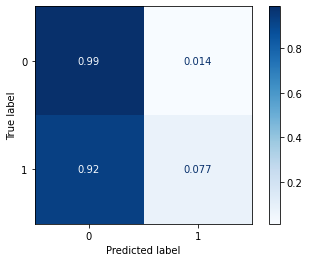

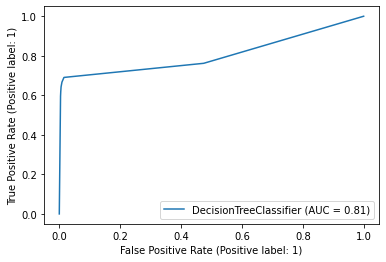

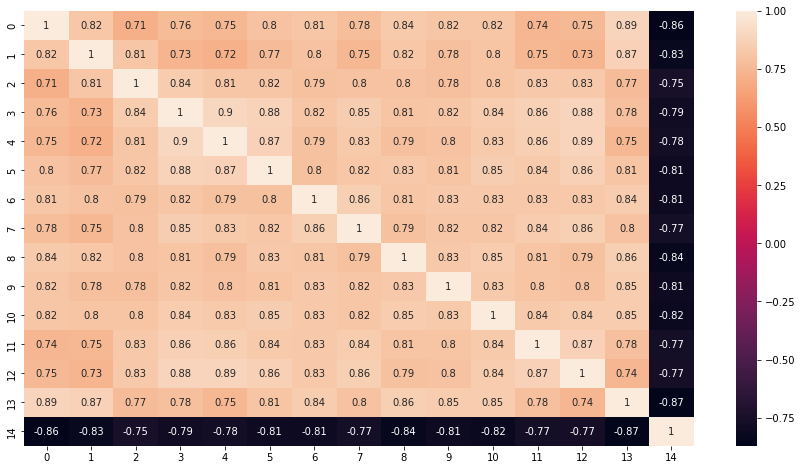

In [117]:
# kernel pca and dt fit

kpca= KernelPCA(n_components=15, kernel = 'rbf', random_state=42, n_jobs=8) ## you can parallelise this

lc_kpca = kpca.fit_transform(lc_ft)
lc_kpca = pd.DataFrame(lc_kpca)

# splitting train and test data

X_train, X_test, y_train, y_test = train_test_split(lc_kpca, targets, test_size=0.30, random_state=42)

# train and test

model.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=[0,1],
    cmap=plt.cm.Blues,
    normalize='true',
)

RocCurveDisplay.from_estimator(model, lc_kpca, targets)

# check correlation

plt.figure(figsize=(15,8))
sns.heatmap(lc_kpca.corr(method='spearman'), annot=True)

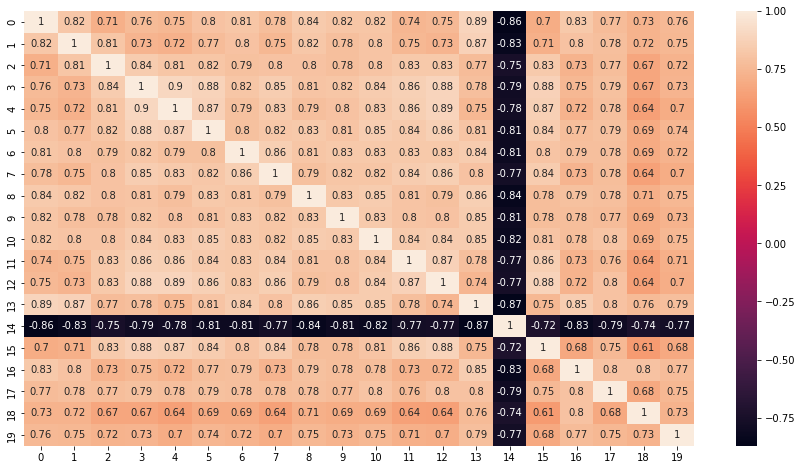

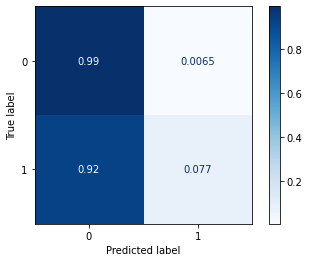

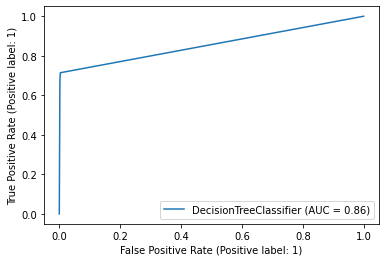

In [118]:
# kernel pca fit

kpca= KernelPCA(n_components=20, kernel = 'rbf', random_state=42, n_jobs=8) ## you can parallelise this

lc_kpca = kpca.fit_transform(lc_ft)
lc_kpca = pd.DataFrame(lc_kpca)

# check correlation

plt.figure(figsize=(15,8))
sns.heatmap(lc_kpca.corr(method='spearman'), annot=True)

# splitting train and test data

X_train, X_test, y_train, y_test = train_test_split(lc_kpca, targets, test_size=0.30, random_state=42)

model.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=[0,1],
    cmap=plt.cm.Blues,
    normalize='true',
)

RocCurveDisplay.from_estimator(model, lc_kpca, targets)

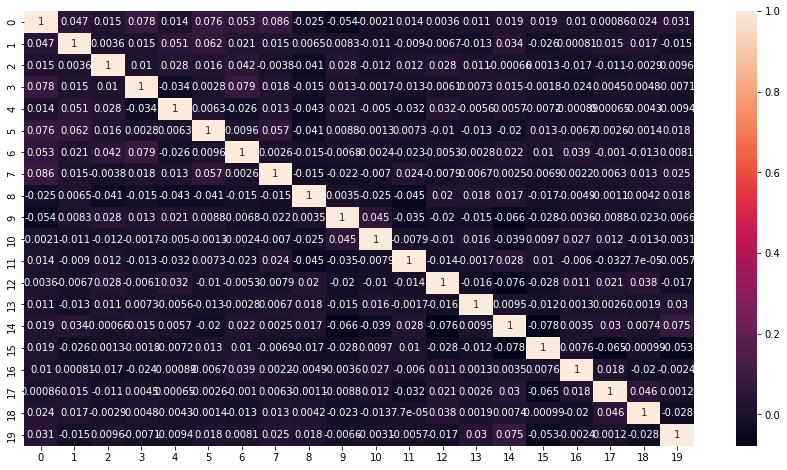

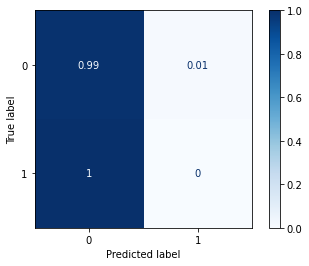

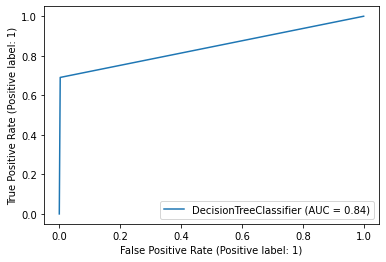

In [119]:
# kernel pca fit

kpca= KernelPCA(n_components=20, kernel = 'cosine', random_state=42, n_jobs=8) ## you can parallelise this

lc_kpca = kpca.fit_transform(lc_ft)
lc_kpca = pd.DataFrame(lc_kpca)

# check correlation

plt.figure(figsize=(15,8))
sns.heatmap(lc_kpca.corr(method='spearman'), annot=True)

# splitting train and test data

X_train, X_test, y_train, y_test = train_test_split(lc_kpca, targets, test_size=0.30, random_state=42)

# train and test

model.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=[0,1],
    cmap=plt.cm.Blues,
    normalize='true',
)

RocCurveDisplay.from_estimator(model, lc_kpca, targets)

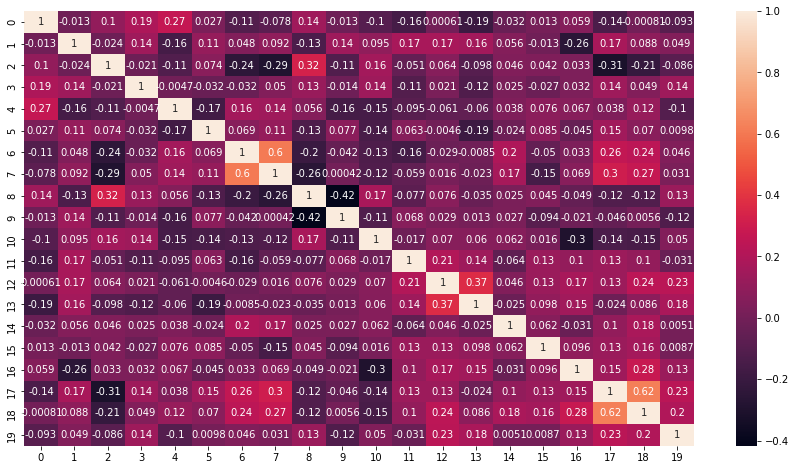

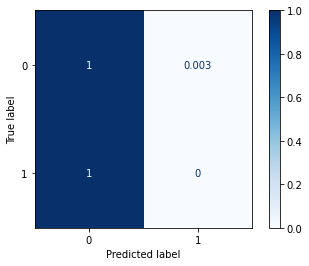

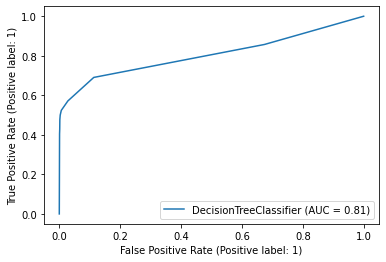

In [120]:
# kernel pca fit

kpca= KernelPCA(n_components=20, kernel = 'poly', random_state=42, n_jobs=8) ## you can parallelise this

lc_kpca = kpca.fit_transform(lc_ft)
lc_kpca = pd.DataFrame(lc_kpca)

# check correlation

plt.figure(figsize=(15,8))
sns.heatmap(lc_kpca.corr(method='spearman'), annot=True)

# splitting train and test data

X_train, X_test, y_train, y_test = train_test_split(lc_kpca, targets, test_size=0.30, random_state=42)

model.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=[0,1],
    cmap=plt.cm.Blues,
    normalize='true',
)

RocCurveDisplay.from_estimator(model, lc_kpca, targets)

Even with Kernel PCA, our model didn't significantly improve.